# Parareal coupling FDTDs of different resolution

In [1]:
using PyPlot
using IterativeSolvers
using Interpolations

#### Define Finite Difference scheme

In [2]:
L = 2.0*pi;
dX = 0.1;
X = collect(0:dX:L);
N = size(X,1);
k = 5;
u = exp.(-4*(X-pi).^2+im*k*(X-pi));
ut = zeros(N);

In [3]:
function fdtd_wave(u0,ut0,dx,t_final)

    c = 1.0;
    dt = dx/5;
    
    u =u0[:];
    ut=ut0[:];
    
    N = size(u,1);

    time = collect(0:dt:t_final);  # time array
    lamda2 = c*dt/dx;
    
    B = spdiagm((ones(N-1),-2*ones(N),ones(N-1)), (-1,0,1))/dx^2;
    B[1,N] = 1.0/dx^2;
    B[N,1] = 1.0/dx^2;
    
    h(y,prevy,yxx) = 2*y-prevy + c^2*dt^2*yxx;
    preu = zeros(N);
    
    for t = time
        # time advancement
        if ( t == 0.0 )
            preu = u[:];
            u = u + dt*ut + 0.5*dt^2*B*u;            
        else
            tempu = u[:];
            uxx = B*u;
            u = h(u,preu,uxx);
            preu = tempu;
        end
    end
    
    ut=(u-preu)/dt + 0.5*c^2*dt*(B*u+B*preu);
    
    return (u,ut)

end

fdtd_wave (generic function with 1 method)

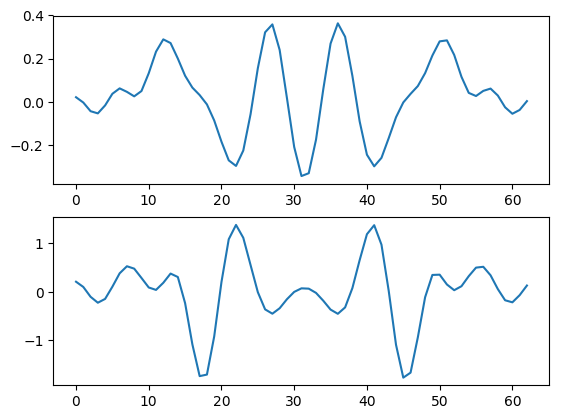

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000022F24160>

In [4]:
u1,ut1=fdtd_wave(u,ut,dX,40);
subplot(2,1,1)
plot(real(u1))
subplot(2,1,2)
plot(real(ut1))

#### Define parareal scheme

In [133]:
function wave1dparareal(u0,ut0,dX,pimax)
    t_final = 40;
    dT = 0.5;
    time = collect(0:dT:t_final);
    Nt = size(time,1);
    Nx = size(u0,1);
    
    u  = complex(zeros(Nx,Nt));
    ut = complex(zeros(Nx,Nt));
    
    u[:,1]  = u0;
    ut[:,1] = ut0;
    
    m = 10.0;
    dx = dX/m;
    
    # initial parareal guess
    for i=2:Nt
        u[:,i],ut[:,i]=fdtd_wave(u[:,i-1],ut[:,i-1],dX,dT);
    end
    
    # parareal iteration
    cfu_update = complex(zeros(Nx,Nt));
    cfut_update= complex(zeros(Nx,Nt));
    #thetap = complex(eye(2*Nx));
    thetap = complex(zeros(2*Nx,2*Nx));
    for pi=1:pimax
        # PARALLEL COMPUTATION
        for i=2:Nt
            ### interpolate u
            itp_u  = interpolate(u[:,i-1],BSpline(Quadratic(Line())), OnGrid());
            u4f  = itp_u[collect(1:1/m:Nx)];
            
            itp_ut = interpolate(ut[:,i-1],BSpline(Quadratic(Line())), OnGrid());
            ut4f  = itp_ut[collect(1:1/m:Nx)];
            ###
            
            u_fine,ut_fine     = fdtd_wave(u4f,ut4f,dx,dT);

            ### downsample u_fine
            itp_u  = interpolate(u_fine,BSpline(Constant()), OnGrid());
            u_fine  = itp_u[collect(1:m:Nx*m)];
            
            itp_ut = interpolate(ut_fine,BSpline(Constant()), OnGrid());
            ut_fine  = itp_ut[collect(1:m:Nx*m)];            
            ###      

            u_coarse,ut_coarse = fdtd_wave(u[:,i-1],ut[:,i-1],dX,dT);
            
            ##### CHANGE parareal \theta parameter here ############
            if i<=100
            thetap = thetap - 2e-6*conj([(u_fine);ut_fine]-thetap*[(u_coarse);ut_coarse])*
                    [(u_coarse.') ut_coarse.'];
            end
            
            cfu_update[:,i]  = u_fine   -  thetap[1:Nx,1:Nx]*u_coarse - thetap[1:Nx,Nx+1:end]*ut_coarse;
            cfut_update[:,i] = ut_fine  -  thetap[Nx+1:end,Nx+1:end]*ut_coarse- thetap[Nx+1:end,1:Nx]*u_coarse;
            
        end        
        
        # SERIAL UPDATE
        for i=2:Nt
            us,uts=fdtd_wave(u[:,i-1],ut[:,i-1],dX,dT);
            
            u[:,i] =thetap[1:Nx,1:Nx]*us + thetap[1:Nx,Nx+1:end]*uts + cfu_update[:,i];
            ut[:,i]=thetap[Nx+1:end,Nx+1:end]*uts+ thetap[Nx+1:end,1:Nx]*us  + cfut_update[:,i];
        end       
            ##### Do not forget \theta initialization ############
        
    end

    figure()
    contourf(abs.(thetap))
    colorbar()
    
    
    return (u,ut)
    
end

wave1dparareal (generic function with 1 method)

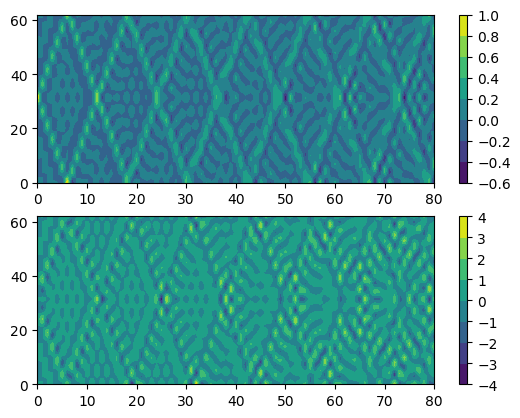

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000042F61C18>

In [39]:
dX=0.1;
u1,ut1=wave1dparareal(u,ut,dX,0);
subplot(2,1,1)
contourf(real(u1))
colorbar()
subplot(2,1,2)
contourf(real(ut1))
colorbar()

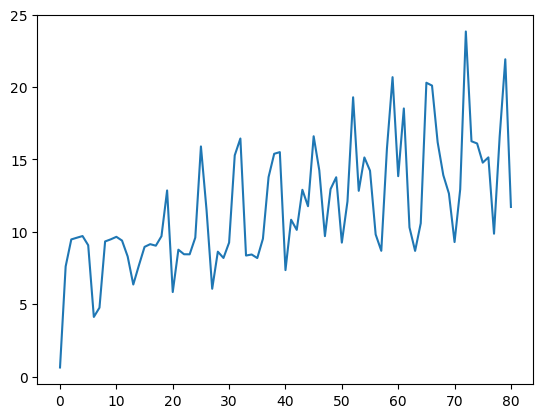

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000003D3032B0>

In [53]:
e1 = [sum(abs.(u1[:,i]).^2+abs.(ut1[:,i]).^2) for i in 1:size(u1,2)];
plot(abs.(e1))

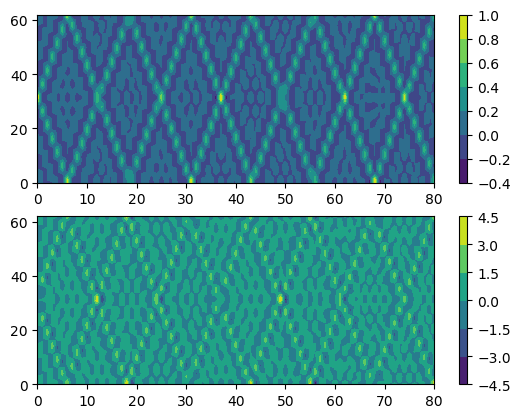

PyObject <matplotlib.colorbar.Colorbar object at 0x000000003DEFC400>

In [41]:
m=10.0;
dx=dX/m;
### interpolate u
itp_u  = interpolate(u,BSpline(Cubic(Line())), OnGrid());
u4f  = itp_u[collect(1:1/m:N)];

itp_ut = interpolate(ut,BSpline(Cubic(Line())), OnGrid());
ut4f  = itp_ut[collect(1:1/m:N)];
###
ub,utb=wave1dparareal(u4f,ut4f,dx,0);
ubdown=complex(zeros(size(u1)));
utbdown=complex(zeros(size(ut1)));
### downsample u_fine
for i=1:size(ub,2)
    itp_u  = interpolate(ub[:,i],BSpline(Constant()), OnGrid());
    ubdown[:,i]  = itp_u[collect(1:m:N*m)];

    itp_ut = interpolate(utb[:,i],BSpline(Constant()), OnGrid());
    utbdown[:,i]  = itp_ut[collect(1:m:N*m)];            
end
###  

subplot(2,1,1)
contourf(real(ubdown))
colorbar()
subplot(2,1,2)
contourf(real(utbdown))
colorbar()

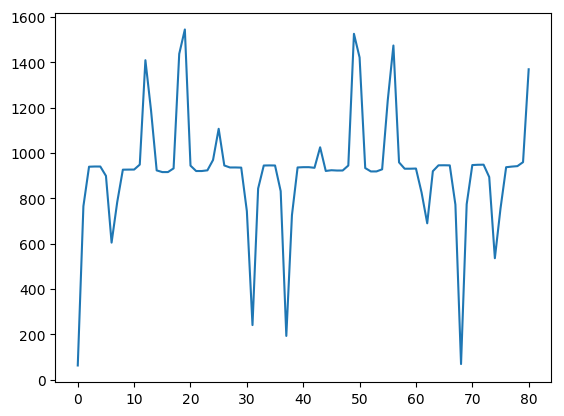

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000003C5D57F0>

In [50]:
eb = [sum(abs.(ub[:,i]).^2+abs.(utb[:,i]).^2) for i in 1:size(ub,2)];
plot(eb)

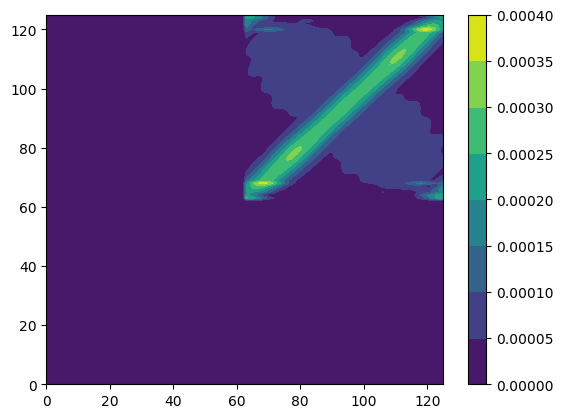

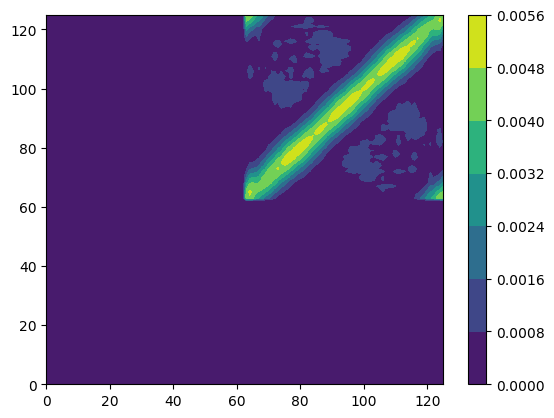

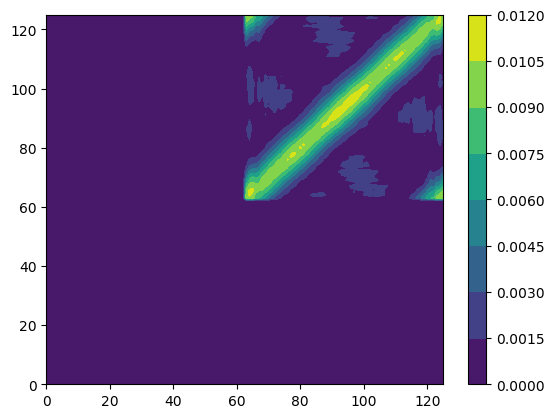

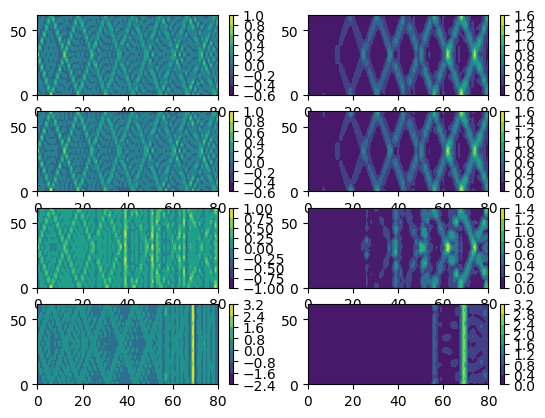

PyObject <matplotlib.colorbar.Colorbar object at 0x00000000AE369C18>

In [134]:
u2,ut2=wave1dparareal(u,ut,dX,1);
u3,ut3=wave1dparareal(u,ut,dX,20);
u4,ut4=wave1dparareal(u,ut,dX,50);

figure()
subplot(4,2,1);contourf(real(u1));colorbar()
subplot(4,2,2);contourf(abs.(u1-ubdown));colorbar()
subplot(4,2,3);contourf(real(u2));colorbar()
subplot(4,2,4);contourf(abs.(u2-ubdown));colorbar()
subplot(4,2,5);contourf(real(u3));colorbar()
subplot(4,2,6);contourf(abs.(u3-ubdown));colorbar()
subplot(4,2,7);contourf(real(u4));colorbar()
subplot(4,2,8);contourf(abs.(u4-ubdown));colorbar()

In [94]:
u4[1,end]

NaN + NaN*im

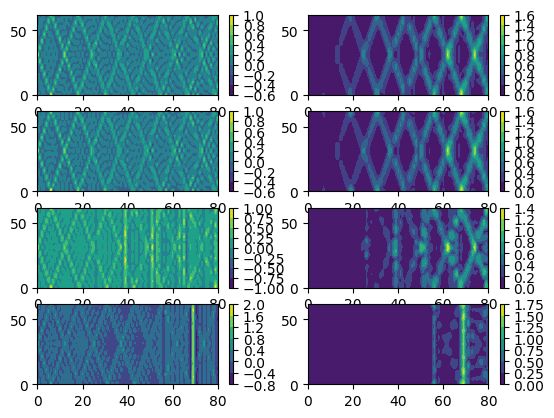

PyObject <matplotlib.colorbar.Colorbar object at 0x000000008DEC6320>

In [102]:
u2,ut2=wave1dparareal(u,ut,dX,1);
u3,ut3=wave1dparareal(u,ut,dX,20);
u4,ut4=wave1dparareal(u,ut,dX,50);

subplot(4,2,1);contourf(real(u1));colorbar()
subplot(4,2,2);contourf(abs.(u1-ubdown));colorbar()
subplot(4,2,3);contourf(real(u2));colorbar()
subplot(4,2,4);contourf(abs.(u2-ubdown));colorbar()
subplot(4,2,5);contourf(real(u3));colorbar()
subplot(4,2,6);contourf(abs.(u3-ubdown));colorbar()
subplot(4,2,7);contourf(real(u4));colorbar()
subplot(4,2,8);contourf(abs.(u4-ubdown));colorbar()

In [128]:
conj(1im)

0 - 1im